### Arboles de decisión
Vamos a entrenar un algoritmo para predecir, en este caso si una persona es o no obesa acorde a su altura y peso. Veremos paso a paso como construir un árbol de decisión. Para ello, contamos con los datos de 500 personas: 

Gender : Male / Female

Height : Number (cm)

Weight : Number (Kg)

Index :

0 - Extremely Weak

1 - Weak

2 - Normal

3 - Overweight

4 - Obesity

5 - Extreme Obesity

Vamos a leer la base de datos. 

In [1]:
'''from google.colab import files
uploaded = files.upload()'''

'from google.colab import files\nuploaded = files.upload()'

In [2]:
import pandas as pd
import numpy as np
import io

data = pd.read_csv('500_Person_Gender_Height_Weight_Index.csv')
data.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


Solo los valores de Index (Índice de obesidad) 4 y 5 corresponden a personas obesas de algun tipo. Crearemos esta variable. 

In [3]:
data['obeso'] = (data.Index >= 4).astype('int').astype('str')
data.drop('Index', axis = 1, inplace = True)


Si pensamos que una persona que pesa 100 kilos puede ser obesa, deberiamos usar el peso como una feature principal. Sin embargo no todas las personas de ese peso son necesariamente obesas. De aqui nos podemos encontrar con subnodos que ayuden a mejorar la predicción como por ejemplo la estatura o el genero. ¿Cómo decidimos cual va primero?

Volvemos al concepto de impureza. Ahora mejor calculamos el indice de Gini, a mano. Por ejemplo, para género.

In [4]:
def gini_impurity(y):
  '''
  Given a Pandas Series, it calculates the Gini Impurity. 
  y: variable with which calculate Gini Impurity.
  '''
  if isinstance(y, pd.Series):
    p = y.value_counts()/y.shape[0]
    gini = 1-np.sum(p**2)
    return(gini)

  else:
    raise('Object must be a Pandas Series.')

gini_impurity(data.Gender)

0.4998

¿Cómo creen que funciona este feature?

Ahora que ya sabemos cómo funciona el índice, veámos cómo funciona la entropía.

In [5]:
def entropy(y):
  '''
  Given a Pandas Series, it calculates the entropy. 
  y: variable with which calculate entropy.
  '''
  if isinstance(y, pd.Series):
    a = y.value_counts()/y.shape[0]
    entropy = np.sum(-a*np.log2(a+1e-9))
    return(entropy)

  else:
    raise('Object must be a Pandas Series.')

entropy(data.Gender)

0.9997114388674198

¿Y ahora?

Ya tenemos ambos resultados, pero aun no sabemos como "ramificar" el árbol.

Vamos ahora a analizar la ganancia de información. 

In [6]:
def variance(y):
  '''
  Function to help calculate the variance avoiding nan.
  y: variable to calculate variance to. It should be a Pandas Series.
  '''
  if(len(y) == 1):
    return 0
  else:
    return y.var()

def information_gain(y, mask, func=entropy):
  '''
  It returns the Information Gain of a variable given a loss function.
  y: target variable.
  mask: split choice.
  func: function to be used to calculate Information Gain in case os classification.
  '''
  
  a = sum(mask)
  b = mask.shape[0] - a
  
  if(a == 0 or b ==0): 
    ig = 0
  
  else:
    if y.dtypes != 'O':
      ig = variance(y) - (a/(a+b)* variance(y[mask])) - (b/(a+b)*variance(y[-mask]))
    else:
      ig = func(y)-a/(a+b)*func(y[mask])-b/(a+b)*func(y[-mask])
  
  return ig

Ahora, podemos calcular la ganancia de información de un corte en concreto:

In [7]:
information_gain(data['obeso'], data['Gender'] == 'Male')

0.0005506911187600494

Deberíamos calcular la ganancia de información en cada una de los cortes posibles, no?
Sin embargo, tenemos una nueva dificultad añadida, y es que ¿cómo elegimos cuál es el mejor split en las variables numéricas? ¿Y en caso de haber más de una variable categórica?

In [8]:
import itertools

def categorical_options(a):
  '''
  Creates all possible combinations from a Pandas Series.
  a: Pandas Series from where to get all possible combinations. 
  '''
  a = a.unique()

  opciones = []
  for L in range(0, len(a)+1):
      for subset in itertools.combinations(a, L):
          subset = list(subset)
          opciones.append(subset)

  return opciones[1:-1]

def max_information_gain_split(x, y, func=entropy):
  '''
  Given a predictor & target variable, returns the best split, the error and the type of variable based on a selected cost function.
  x: predictor variable as Pandas Series.
  y: target variable as Pandas Series.
  func: function to be used to calculate the best split.
  '''

  split_value = []
  ig = [] 

  numeric_variable = True if x.dtypes != 'O' else False

  # Create options according to variable type
  if numeric_variable:
    options = x.sort_values().unique()[1:]
  else: 
    options = categorical_options(x)

  # Calculate ig for all values
  for val in options:
    mask =   x < val if numeric_variable else x.isin(val)
    val_ig = information_gain(y, mask, func)
    # Append results
    ig.append(val_ig)
    split_value.append(val)

  # Check if there are more than 1 results if not, return False
  if len(ig) == 0:
    return(None,None,None, False)

  else:
  # Get results with highest IG
    best_ig = max(ig)
    best_ig_index = ig.index(best_ig)
    best_split = split_value[best_ig_index]
    return(best_ig,best_split,numeric_variable, True)


weight_ig, weight_slpit, _, _ = max_information_gain_split(data['Weight'], data['obeso'],)  


print(
  "El mejor split para Weight es cuando la variable es inferior a ",
  weight_slpit,"\nLa ganancia de información para ese corte es:", weight_ig
)

El mejor split para Weight es cuando la variable es inferior a  103 
La ganancia de información para ese corte es: 0.3824541370911895


Como vemos, la variable con mayor ganancia de información es Weight. Asi, la variable que utilicemos primero para hacer el split es esta. Cuyo corte es igual a 103.

Ahora que ya sabemos calcular el split de una variable, veámos cómo decidir el mejor split. Esto es cuando la ganancia de informacion es alta. 

In [9]:
data.drop('obeso', axis= 1).apply(max_information_gain_split, y = data['obeso'])

,Gender,Height,Weight
0,0.000551,0.064748,0.382454
1,[Male],174,103
2,False,True,True
3,True,True,True




Con esto, ya tendríamos el primer split, el cual generaría dos dataframes. De manera recursiva, terminaremos creando el árbol de decisión completo.

### Cómo entrenar un árbol de decisión

Ahora vamos a definir un árbol de decisión. 

Además, necesitamos evitar que el árbol crezca demasiado, ¿para qué?. 

Para esto determinaremos algunos hiperparámetros:

* ***max_depth:** profundidad máxima del árbol. Si lo fijamos en None, el árbol crecerá hasta que todas las hojas sean puras o se haya alcanzado el hiperparámetro min_samples_split.
* **min_samples_split:** indica el número mínimo de observaciones que debe tener una hoja para seguir creando nuevos nodos.
* **min_information_gain:** la cantidad mínima que debe incrementar el Information Gain para que el árbol siga creciendo.

Teniendo esto en cuenta, vamos a seguir los pasos:



1.   Comprobar que se cumplen las condiciones fijadas por *min_samples_split* y *max_depth*. 
2.   Hacer el split.
3.   Guardar los datos del split y repetir.

Para ello, lo primero de todo es crear tres funciones: una que, dado unos datos, devuelva el mejor split con su información correspondiente, otra, que dado unos datos y un split, haga el split y nos devuelva la predicción y por último, una función que dados unos datos, haga una predicción.

Nota: la predicción solo se dará en las ramas y básicamente consiste en devolver la media de los datos en caso de la regresión o la moda en caso de la clasificación.

In [10]:
def get_best_split(y, data):
  '''
  Given a data, select the best split and return the variable, the value, the variable type and the information gain.
  y: name of the target variable
  data: dataframe where to find the best split.
  '''
  masks = data.drop(y, axis= 1).apply(max_information_gain_split, y = data[y])
  if sum(masks.loc[3,:]) == 0:
    return(None, None, None, None)

  else:
    # Get only masks that can be splitted
    masks = masks.loc[:,masks.loc[3,:]]

    # Get the results for split with highest IG
    split_variable = max(masks)
    #split_valid = masks[split_variable][]
    split_value = masks[split_variable][1] 
    split_ig = masks[split_variable][0]
    split_numeric = masks[split_variable][2]

    return(split_variable, split_value, split_ig, split_numeric)


def make_split(variable, value, data, is_numeric):
  '''
  Given a data and a split conditions, do the split.
  variable: variable with which make the split.
  value: value of the variable to make the split.
  data: data to be splitted.
  is_numeric: boolean considering if the variable to be splitted is numeric or not.
  '''
  if is_numeric:
    data_1 = data[data[variable] < value]
    data_2 = data[(data[variable] < value) == False]

  else:
    data_1 = data[data[variable].isin(value)]
    data_2 = data[(data[variable].isin(value)) == False]

  return(data_1,data_2)

def make_prediction(data, target_factor):
  '''
  Given the target variable, make a prediction.
  data: pandas series for target variable
  target_factor: boolean considering if the variable is a factor or not
  '''

  # Make predictions
  if target_factor:
    pred = data.value_counts().idxmax()
  else:
    pred = data.mean()

  return pred

In [11]:
def train_tree(data,y, target_factor, max_depth = None,min_samples_split = None, min_information_gain = 1e-20, counter=0, max_categories = 20):
  '''
  Trains a Decission Tree
  data: Data to be used to train the Decission Tree
  y: target variable column name
  target_factor: boolean to consider if target variable is factor or numeric.
  max_depth: maximum depth to stop splitting.
  min_samples_split: minimum number of observations to make a split.
  min_information_gain: minimum ig gain to consider a split to be valid.
  max_categories: maximum number of different values accepted for categorical values. High number of values will slow down learning process. R
  '''

  # Check that max_categories is fulfilled
  if counter==0:
    types = data.dtypes
    check_columns = types[types == "object"].index
    for column in check_columns:
      var_length = len(data[column].value_counts()) 
      if var_length > max_categories:
        raise ValueError('The variable ' + column + ' has '+ str(var_length) + ' unique values, which is more than the accepted ones: ' +  str(max_categories))

  # Check for depth conditions
  if max_depth == None:
    depth_cond = True

  else:
    if counter < max_depth:
      depth_cond = True

    else:
      depth_cond = False

  # Check for sample conditions
  if min_samples_split == None:
    sample_cond = True

  else:
    if data.shape[0] > min_samples_split:
      sample_cond = True

    else:
      sample_cond = False

  # Check for ig condition
  if depth_cond & sample_cond:

    var,val,ig,var_type = get_best_split(y, data)

    # If ig condition is fulfilled, make split 
    if ig is not None and ig >= min_information_gain:

      counter += 1

      left,right = make_split(var, val, data,var_type)

      # Instantiate sub-tree
      split_type = "<=" if var_type else "in"
      question =   "{} {}  {}".format(var,split_type,val)
      # question = "\n" + counter*" " + "|->" + var + " " + split_type + " " + str(val) 
      subtree = {question: []}


      # Find answers (recursion)
      yes_answer = train_tree(left,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      no_answer = train_tree(right,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      if yes_answer == no_answer:
        subtree = yes_answer

      else:
        subtree[question].append(yes_answer)
        subtree[question].append(no_answer)

    # If it doesn't match IG condition, make prediction
    else:
      pred = make_prediction(data[y],target_factor)
      return pred

   # Drop dataset if doesn't match depth or sample conditions
  else:
    pred = make_prediction(data[y],target_factor)
    return pred

  return subtree


max_depth = 5
min_samples_split = 20
min_information_gain  = 1e-5


decisiones = train_tree(data,'obeso',True, max_depth,min_samples_split,min_information_gain)


decisiones

{'Weight <=  103': [{'Weight <=  66': ['0',
    {'Weight <=  84': [{'Weight <=  74': ['0', {'Weight <=  75': ['1', '0']}]},
      {'Weight <=  98': ['1', '0']}]}]},
  '1']}

Listo!

### Graficar árbol de decisión

Antes de poder representar un árbol de decisión en primer lugar se ha de crear un modelo. Para ello se puede simular un conjunto de datos con el método make_blobs de scikit-learn.

In [12]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50,
                  centers=3,
                  random_state=0,
                  cluster_std=0.60)
feature_names = ['X', 'Y']


ModuleNotFoundError: No module named 'sklearn.datasets.samples_generator'

En este conjunto de datos se han creado tres burbujas en un espacio bidimensional. A la primera característica se la ha llamado X e Y a la segunda. El resultado se puede representar gráficamente con el siguiente código.

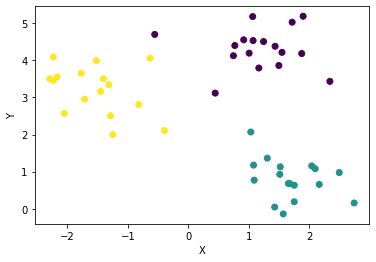

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.show()

Representación de los datos para el entrenamiento del árbol de decisión

Ahora se puede emplear la clase DecisionTreeClassifier para el entrenamiento de un árbol de decisión.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0).fit(X, y)

La visualización del árbol se puede realizar con el siguiente código.

In [ ]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
dot_data = export_graphviz(tree,
                           feature_names=feature_names)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')


True

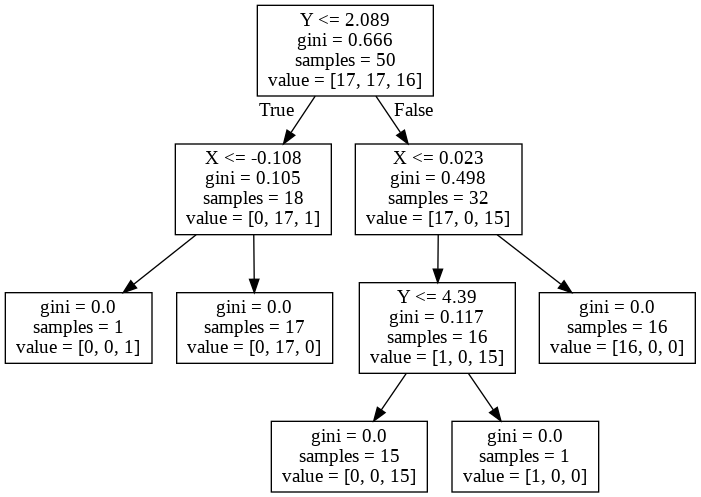

In [ ]:
from IPython.display import Image 
Image(graph.create_png())

### Arbol de decisión más fácil

Vamos a trabajar con los datos de Titanic nuevamente

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_titanic.csv to train_titanic (1).csv


In [ ]:
import pandas as pd
#import numpy as np
import io

train = pd.read_csv(io.StringIO(uploaded['train_titanic.csv'].decode('utf-8')))
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Entrenamos el árbol de clasificación con **sklearn**. 

Cargamos las librerias necesarias

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

Y hacemos la división de la base de datos

In [ ]:
train = pd.get_dummies(train, columns=['Sex'], drop_first=True)
X = train[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp']]
X["Age"].fillna(X["Age"].median(skipna=True), inplace=True)
X.head()


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,Sex_male,Fare,Age,Pclass,SibSp
0,1,7.2500,22.0,3,1
1,0,71.2833,38.0,1,1
2,0,7.9250,26.0,3,0
3,0,53.1000,35.0,1,1
4,1,8.0500,35.0,3,0


In [ ]:
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


Ahora vamos a estimar el arbol de decisión 

In [ ]:
model = DecisionTreeClassifier(random_state=1).fit(X_train,y_train)
y_predicted = model.predict(X_test)
print('Training accuracy: ',model.score(X_train,y_train))
print('Test Accuracy: ',model.score(X_test,y_test))

Training accuracy:  0.9887640449438202
Test Accuracy:  0.7425373134328358


DecisionTreeClassifier en sklearn proporciona ccp_alpha como parámetro para la poda posterior. El parámetro ccp_alpha proporciona un umbral para alfas efectivas , es decir, el proceso de poda continúa hasta que el alfa mínimo efectivo del árbol podado no es mayor que ccp_alpha. DecisionTreeClassifier también proporciona un método cost_complexity_pruning_path que implementa el proceso de poda y devuelve los alfas efectivos (y las impurezas correspondientes de los árboles podados)

In [ ]:
path=DecisionTreeClassifier(random_state=1).\
cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

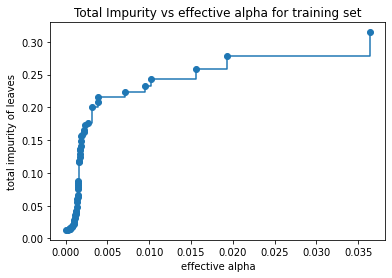

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

A continuación, construimos un bosque de árboles con diferentes valores de ccp_alpha extraídos de cost_complexity_pruning_path en orden. El último árbol será el nodo raíz

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1,ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [ ]:
print("Number of nodes in the last tree is: {} with ccp_alpha: {} and a depth of: {}".format(
clfs[-1].tree_.node_count, ccp_alphas[-1],clfs[-1].tree_.max_depth))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1486931782834917 and a depth of: 0


In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

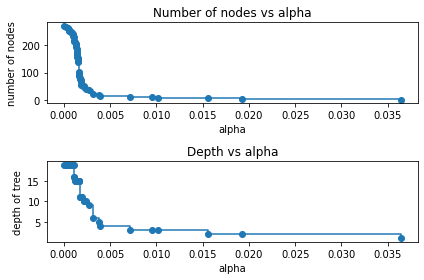

In [ ]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Obtenemos la lista de puntuaciones medias de precisión de pruebas y trenes para cada uno de los árboles (restantes) y comprobamos cómo cambian las puntuaciones de precisión de pruebas / trenes con el cambio en ccp_alpha 

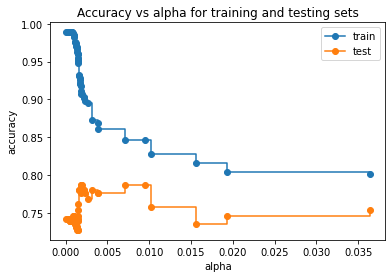

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

Ahora extraemos el "mejor" clasificador que dará la máxima puntuación de precisión en la prueba.

In [ ]:
index_best_model = np.argmax(test_scores)
best_model = clfs[index_best_model]
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_test, y_test))

Training accuracy of best model:  0.9117174959871589
Test accuracy of best model:  0.7873134328358209
